RA vs Normal

Epoch 1: Train Loss: 0.5250, Train Acc: 0.7291, Val Loss: 0.6442, Val Acc: 0.6481
Epoch 2: Train Loss: 0.2646, Train Acc: 0.9203, Val Loss: 0.5519, Val Acc: 0.8889
Epoch 3: Train Loss: 0.1158, Train Acc: 0.9920, Val Loss: 0.4981, Val Acc: 0.7778
Epoch 4: Train Loss: 0.0681, Train Acc: 1.0000, Val Loss: 0.4601, Val Acc: 0.8148
Epoch 5: Train Loss: 0.0744, Train Acc: 0.9880, Val Loss: 0.4385, Val Acc: 0.7963
Epoch 6: Train Loss: 0.0533, Train Acc: 0.9920, Val Loss: 0.5155, Val Acc: 0.7222
Epoch 7: Train Loss: 0.0432, Train Acc: 0.9960, Val Loss: 0.3260, Val Acc: 0.8704
Epoch 8: Train Loss: 0.0259, Train Acc: 1.0000, Val Loss: 0.2393, Val Acc: 0.9074
Epoch 9: Train Loss: 0.0273, Train Acc: 1.0000, Val Loss: 0.2342, Val Acc: 0.9259
Epoch 10: Train Loss: 0.0282, Train Acc: 1.0000, Val Loss: 0.1961, Val Acc: 0.9259
Training Complete!
Test Loss: 0.0892, Test Accuracy: 0.9636


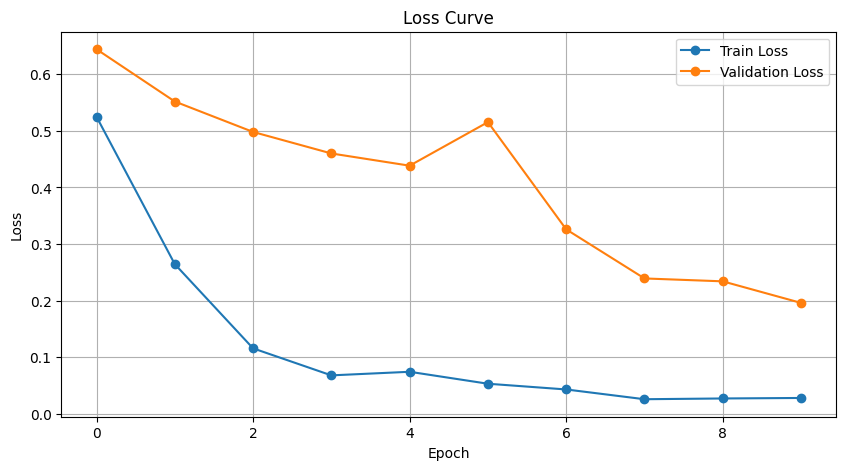

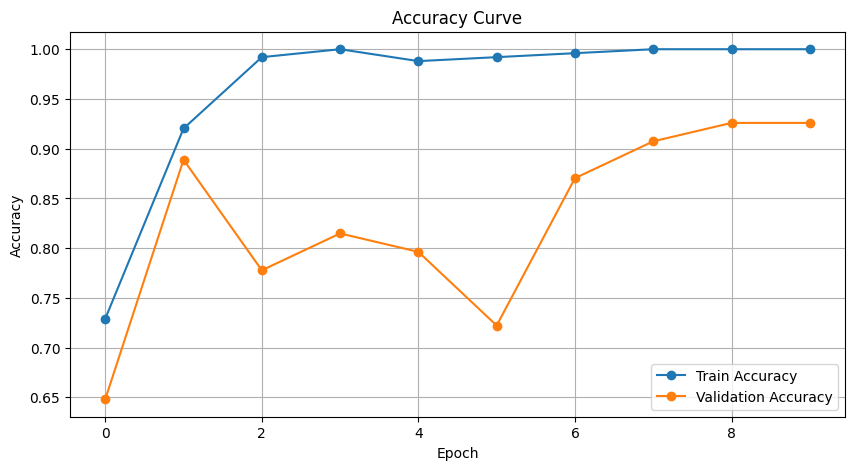

In [3]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model  # Swin Transformer
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------

# Load dataset from pickle file
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Specify classification task: choose 'oa', 'ra', 'gout' vs 'normal'
task_classes = ['ra', 'normal']  # Change this to ['ra', 'normal'] or ['gout', 'normal'] as needed

class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

# Balance dataset for fairness
for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())  # Balance dataset
balanced_data = []
for cls in task_classes:
    sampled_data = random.sample(data_by_class[cls], min_class_count)
    balanced_data.extend(sampled_data)

augmented_data = balanced_data * 2  # Data Augmentation

# -------------------------------
# 2. Dataset and DataLoader
# -------------------------------

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(patch) for patch in patches[:34]]
            patch_tensors = [self.patch_transform(patch) for patch in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)
        else:
            combined_patches = torch.zeros(34 * 3, 112, 112)

        label = 1 if entry['class'].lower() == task_classes[0] else 0
        return image, combined_patches, label

full_dataset = FootDataset(augmented_data, train_transform, patch_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -------------------------------
# 3. Define Model
# -------------------------------

class FeatureAttention(nn.Module):
    def __init__(self, feature_dim):
        super(FeatureAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(feature_dim * 4, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, 4),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Linear(feature_dim, 512)

    def forward(self, feature_list):
        combined = torch.cat(feature_list, dim=1)
        weights = self.attention(combined)
        weighted_features = torch.stack(feature_list, dim=1) * weights.unsqueeze(-1)
        weighted_features = weighted_features.sum(dim=1)
        return self.fc(weighted_features)

class TwoBranchModel(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchModel, self).__init__()

        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch = models.resnet50(pretrained=pretrained)
        feature_dim = resnet_global.fc.in_features

        resnet_global.fc = nn.Identity()
        resnet_patch.fc = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch = resnet_patch

        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)

        self.feature_attention = FeatureAttention(feature_dim)

        swin_feature_dim = 768
        self.swin_global_fc = nn.Linear(swin_feature_dim, feature_dim)
        self.swin_patch_fc = nn.Linear(swin_feature_dim, feature_dim)

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, image, patches):
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        patches_reduced = self.patch_channel_reduction(patches_resized)

        swin_global_features = self.swin_global.forward_features(image).mean(dim=[1, 2])
        swin_patch_features = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])
        resnet_global_features = self.resnet_global(image)
        resnet_patch_features = self.resnet_patch(patches_reduced).view(patches.size(0), -1)

        swin_global_features = self.swin_global_fc(swin_global_features)
        swin_patch_features = self.swin_patch_fc(swin_patch_features)

        combined_features = self.feature_attention([
            swin_global_features, swin_patch_features, 
            resnet_global_features, resnet_patch_features
        ])

        return self.classifier(combined_features)

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchModel(pretrained=True).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, patches, labels in dataloader:
            images, patches, labels = images.to(device), patches.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images, patches)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Training Loop with Validation Evaluation
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, patches, labels in train_loader:
        images, patches, labels = images.to(device), patches.to(device), labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images, patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        
        preds = (outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Training Complete!")

# -------------------------------
# Test Phase
# -------------------------------
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot Training Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()
plt.show()


With Saving Encodding Vectors


✅ Embeddings saved to embeddings_ra_vs_normal.pt
Epoch 1: Train Loss: 0.5181, Train Acc: 0.7490, Val Loss: 0.6587, Val Acc: 0.7778
Epoch 2: Train Loss: 0.2634, Train Acc: 0.8964, Val Loss: 0.5865, Val Acc: 0.7222
Epoch 3: Train Loss: 0.1047, Train Acc: 0.9801, Val Loss: 0.5048, Val Acc: 0.8333
Epoch 4: Train Loss: 0.0570, Train Acc: 0.9920, Val Loss: 0.4759, Val Acc: 0.8148
Epoch 5: Train Loss: 0.0391, Train Acc: 1.0000, Val Loss: 0.2930, Val Acc: 0.9259
Epoch 6: Train Loss: 0.0281, Train Acc: 1.0000, Val Loss: 0.2195, Val Acc: 0.9630
Epoch 7: Train Loss: 0.0166, Train Acc: 1.0000, Val Loss: 0.2281, Val Acc: 0.9444
Epoch 8: Train Loss: 0.0130, Train Acc: 1.0000, Val Loss: 0.2076, Val Acc: 0.9444
Epoch 9: Train Loss: 0.0228, Train Acc: 1.0000, Val Loss: 0.5895, Val Acc: 0.7593
Epoch 10: Train Loss: 0.0416, Train Acc: 1.0000, Val Loss: 0.4461, Val Acc: 0.8333
Training Complete!
Test Loss: 0.2949, Test Accuracy: 0.8727


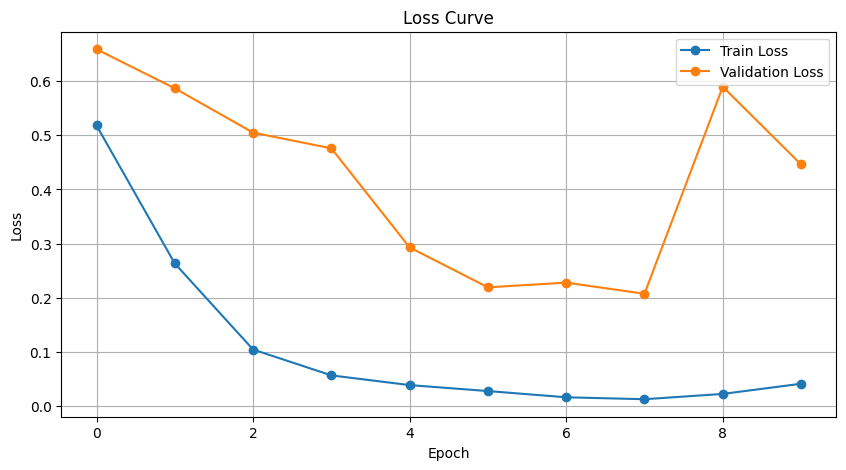

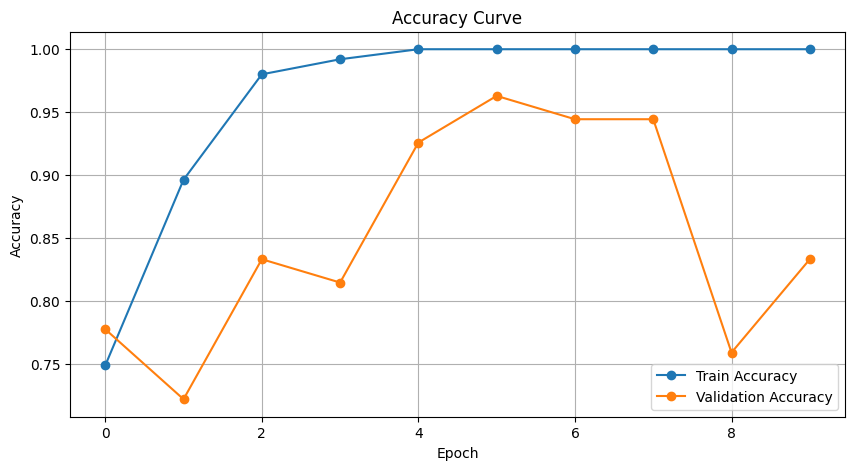

In [7]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Load dataset from pickle file
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Specify classification task
task_classes = ['ra', 'normal']  # Change to ['oa', 'normal'] or ['gout', 'normal']

# Balance dataset
class_counts = {cls: 0 for cls in task_classes}
data_by_class = {cls: [] for cls in task_classes}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

min_class_count = min(class_counts.values())  
balanced_data = [random.sample(data_by_class[cls], min_class_count) for cls in task_classes]
balanced_data = sum(balanced_data, [])  # Flatten list

augmented_data = balanced_data * 2  # Data Augmentation


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class FootDataset(Dataset):
    def __init__(self, data, image_transform, patch_transform):
        self.data = data
        self.image_transform = image_transform
        self.patch_transform = patch_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        image = self.image_transform(image)

        patches = entry.get('bbx', [])
        if len(patches) > 0:
            patch_images = [Image.fromarray(patch) for patch in patches[:34]]
            patch_tensors = [self.patch_transform(patch) for patch in patch_images]
            combined_patches = torch.cat(patch_tensors, dim=0)
        else:
            combined_patches = torch.zeros(34 * 3, 112, 112)

        label = 1 if entry['class'].lower() == task_classes[0] else 0
        return image, combined_patches, label, entry['file_path']

full_dataset = FootDataset(augmented_data, train_transform, patch_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class FeatureAttention(nn.Module):
    def __init__(self, feature_dim):
        super(FeatureAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(feature_dim * 4, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, 4),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Linear(feature_dim, 512)

    def forward(self, feature_list):
        combined = torch.cat(feature_list, dim=1)
        weights = self.attention(combined)
        weighted_features = torch.stack(feature_list, dim=1) * weights.unsqueeze(-1)
        weighted_features = weighted_features.sum(dim=1)
        return self.fc(weighted_features)

class TwoBranchModel(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchModel, self).__init__()

        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()

        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch = models.resnet50(pretrained=pretrained)
        feature_dim = resnet_global.fc.in_features

        resnet_global.fc = nn.Identity()
        resnet_patch.fc = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch = resnet_patch

        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)

        self.feature_attention = FeatureAttention(feature_dim)

        swin_feature_dim = 768
        self.swin_global_fc = nn.Linear(swin_feature_dim, feature_dim)
        self.swin_patch_fc = nn.Linear(swin_feature_dim, feature_dim)

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, image, patches):
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        patches_reduced = self.patch_channel_reduction(patches_resized)

        swin_global_features = self.swin_global.forward_features(image).mean(dim=[1, 2])
        swin_patch_features = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])
        resnet_global_features = self.resnet_global(image)
        resnet_patch_features = self.resnet_patch(patches_reduced).view(patches.size(0), -1)

        swin_global_features = self.swin_global_fc(swin_global_features)
        swin_patch_features = self.swin_patch_fc(swin_patch_features)

        combined_features = self.feature_attention([
            swin_global_features, swin_patch_features, 
            resnet_global_features, resnet_patch_features
        ])

        classifier_output = self.classifier(combined_features)

        return classifier_output, combined_features  

def save_embeddings(model, dataloader, task_classes):
    model.eval()
    embeddings = []
    file_paths = []
    
    with torch.no_grad():
        for images, patches, _, file_path in dataloader:
            images, patches = images.to(device), patches.to(device)
            _, features = model(images, patches)  # Extract embeddings
            embeddings.append(features.cpu().numpy())
            file_paths.extend(file_path)

    embeddings = np.vstack(embeddings)
    
    save_path = f"embeddings_{task_classes[0]}_vs_{task_classes[1]}.pt"
    torch.save({"embeddings": embeddings, "file_paths": file_paths}, save_path)
    
    print(f"✅ Embeddings saved to {save_path}")

# Now call the function correctly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchModel(pretrained=True).to(device)

save_embeddings(model, test_loader, task_classes)

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, patches, labels, _ in dataloader: 
            images, patches, labels = images.to(device), patches.to(device), labels.float().to(device).unsqueeze(1)
            outputs, _ = model(images, patches) 
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


# Training Loop with Validation Evaluation
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, patches, labels, _ in train_loader:
        images, patches, labels = images.to(device), patches.to(device), labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs, _ = model(images, patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()

        preds = (outputs >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)


    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Training Complete!")

# -------------------------------
# Test Phase
# -------------------------------
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot Training Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()
plt.show()

